In [11]:
#!/usr/bin/env python3
# train_and_evaluate.py

from pathlib import Path
import json, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt

# ----------------- 하이퍼파라미터 ----------------------
DATA_ROOT     = Path("embbeding_data")
AGG_METHOD    = "mean"
BATCH         = 64
EPOCHS        = 100
LR            = 1e-4
WEIGHT_DECAY  = 1e-4
HIDDEN_DIMS   = (1024, 256)
DROPOUT_P     = 0.5
DEVICE        = "cuda:0" if torch.cuda.is_available() else "cpu"
SAVE_DIR      = Path("fusion_ckpt")
EARLY_STOP    = 10     # 조기 종료 patience
MIXUP_ALPHA   = 0.2    # Mixup 적용 강도
WARMUP_EPOCHS = 10     # Warmup 에폭 수

# ----------------- 데이터 로딩 및 정규화 -------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    raise ValueError(f"AGG_METHOD={AGG_METHOD}")
# ------------------ Mixup 함수 ----------------------
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ------------------ Warmup scheduler ------------------
def linear_warmup_scheduler(optimizer, warmup_epochs, total_epochs, base_lr):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / float(max(1, warmup_epochs))
        return 1.0
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------ MLP 모델 정의 ----------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden, p_drop):
        super().__init__()
        layers, dims = [], [in_dim, *hidden]
        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [
                nn.Linear(d_in, d_out),
                nn.BatchNorm1d(d_out),
                nn.ReLU(),
                nn.Dropout(p_drop)
            ]
        layers += [nn.Linear(dims[-1], n_cls)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ------------------ 데이터 결합 및 정규화 ------------------
ts_tr, y_tr = load_split("train", "timesformer")
st_tr, _    = load_split("train", "stgcnpp")
ts_va, y_va = load_split("valid", "timesformer")
st_va, _    = load_split("valid", "stgcnpp")

st_tr = reduce_stgcn(st_tr)
st_va = reduce_stgcn(st_va)

X_tr = np.concatenate([ts_tr, st_tr], axis=1)
X_va = np.concatenate([ts_va, st_va], axis=1)

# ▶ StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr).astype(np.float32)
X_va = scaler.transform(X_va).astype(np.float32)
y_tr = y_tr.astype(np.int64)
y_va = y_va.astype(np.int64)

# ------------------ DataLoaders ------------------
dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
                   batch_size=BATCH, shuffle=True)
dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va)),
                   batch_size=BATCH, shuffle=False)

# ------------------ 모델, 옵티마이저, 스케줄러 ------------------
model = FusionMLP(in_dim=X_tr.shape[1], n_cls=2,
                  hidden=HIDDEN_DIMS, p_drop=DROPOUT_P).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = linear_warmup_scheduler(opt, warmup_epochs=5, total_epochs=EPOCHS, base_lr=LR)

# Label Smoothing
crit = nn.CrossEntropyLoss(label_smoothing=0.1)

# ------------------ EarlyStopping ------------------
early_stop_patience = 10
early_stop_counter = 0
best_val_acc = 0.0
best_state = None

# ------------------ 학습 루프 ------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    sum_loss, sum_correct, total = 0.0, 0, 0

    for x, y in dl_tr:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x, y_a, y_b, lam = mixup_data(x, y, alpha=1.0)
        opt.zero_grad()
        pred = model(x)
        loss = mixup_criterion(crit, pred, y_a, y_b, lam)
        loss.backward()
        opt.step()
        sum_loss += loss.item() * y.size(0)
        sum_correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)

    tr_loss = sum_loss / total
    tr_acc  = sum_correct / total

    model.eval()
    v_loss_sum, correct, total = 0.0, 0, 0
    all_probs, all_preds, all_trues = [], [], []

    with torch.no_grad():
        for x, y in dl_va:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = crit(out, y)
            v_loss_sum += loss.item() * y.size(0)
            total += y.size(0)
            preds = out.argmax(1)
            all_probs.extend(torch.softmax(out, 1)[:, 1].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(y.cpu().numpy())

    val_loss = v_loss_sum / total
    val_acc = accuracy_score(all_trues, all_preds)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("⏹ Early stopping triggered!")
            break

# ------------------ 평가 및 저장 ------------------
SAVE_DIR.mkdir(parents=True, exist_ok=True)
torch.save(best_state, SAVE_DIR / "fusion_mlp_best.pth")
model.load_state_dict(best_state)
model.eval()

# 최종 예측
with torch.no_grad():
    x_tensor = torch.from_numpy(X_va).to(DEVICE)
    out = model(x_tensor)
    probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
    preds = out.argmax(1).cpu().numpy()
    trues = y_va

fpr, tpr, _ = roc_curve(trues, probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(trues, preds)
report = classification_report(trues, preds, digits=4, output_dict=True)

# 저장
with open(SAVE_DIR / "metrics.json", "w", encoding="utf-8") as jf:
    json.dump({
        "accuracy": accuracy_score(trues, preds),
        "roc_auc": roc_auc,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }, jf, indent=2)

# 시각화
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.savefig(SAVE_DIR / "roc_curve.png"); plt.close()

plt.matshow(cm, cmap='Blues')
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,str(v),ha='center',va='center')
plt.xlabel('Pred'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.savefig(SAVE_DIR / "confusion_matrix.png"); plt.close()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(True)
plt.savefig(SAVE_DIR / "loss_curve.png"); plt.close()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Valid Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Curve"); plt.legend(); plt.grid(True)
plt.savefig(SAVE_DIR / "accuracy_curve.png"); plt.close()

print(f"✅ All metrics saved in {SAVE_DIR.resolve()}")


[01/100] train_loss=0.7695, train_acc=0.5179, val_loss=0.6733, val_acc=0.6136
[02/100] train_loss=0.7500, train_acc=0.4847, val_loss=0.6448, val_acc=0.7500
[03/100] train_loss=0.7410, train_acc=0.5255, val_loss=0.6060, val_acc=0.8636
[04/100] train_loss=0.7048, train_acc=0.5663, val_loss=0.5660, val_acc=0.8409
[05/100] train_loss=0.6690, train_acc=0.6250, val_loss=0.5397, val_acc=0.8409
[06/100] train_loss=0.6076, train_acc=0.6811, val_loss=0.5225, val_acc=0.8182
[07/100] train_loss=0.6036, train_acc=0.6556, val_loss=0.4927, val_acc=0.8182
[08/100] train_loss=0.5827, train_acc=0.6658, val_loss=0.4766, val_acc=0.8636
[09/100] train_loss=0.5657, train_acc=0.6913, val_loss=0.4495, val_acc=0.8409
[10/100] train_loss=0.5364, train_acc=0.7143, val_loss=0.4448, val_acc=0.8182
[11/100] train_loss=0.5376, train_acc=0.7143, val_loss=0.4519, val_acc=0.8409
[12/100] train_loss=0.5249, train_acc=0.7015, val_loss=0.4462, val_acc=0.8409
[13/100] train_loss=0.4876, train_acc=0.8189, val_loss=0.4401, v

              precision    recall  f1-score   support

           0     0.0500    1.0000    0.0952         1
           1     1.0000    0.5250    0.6885        40

    accuracy                         0.5366        41
   macro avg     0.5250    0.7625    0.3919        41
weighted avg     0.9768    0.5366    0.6741        41

Test Accuracy: 53.66%


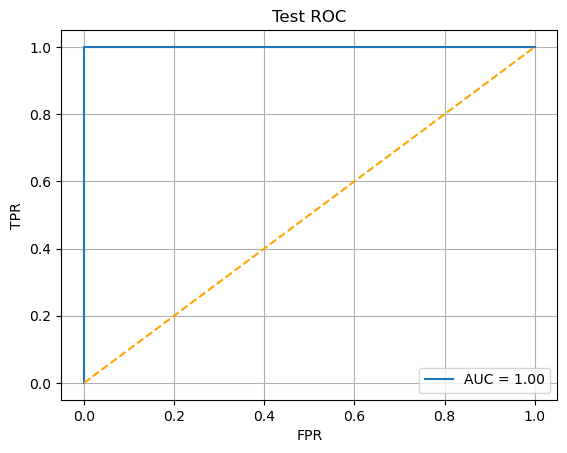

<Figure size 640x480 with 0 Axes>

In [12]:
from pathlib import Path
import numpy as np, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ----------------- 환경 설정 --------------------------------------------
DATA_ROOT   = Path("embbeding_data")
AGG_METHOD  = "mean"
BATCH       = 64
HIDDEN_DIMS = (1024, 256)
DROPOUT_P   = 0.5
DEVICE      = "cuda:0" if torch.cuda.is_available() else "cpu"
MODEL_DIR   = Path("fusion_ckpt")
SAVE_DIR    = Path("fusion_ckpt/test")

SAVE_DIR.mkdir(parents=True, exist_ok=True)

# ----------------- 데이터 로드 --------------------------------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    elif AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    elif AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    else:
        raise ValueError(f"Invalid AGG_METHOD: {AGG_METHOD}")

# ----------------- 테스트 데이터 준비 --------------------------------------
ts_te, y_te = load_split("test", "timesformer")
st_te, _    = load_split("test", "stgcnpp")
st_te_flat  = reduce_stgcn(st_te)

X_te = np.concatenate([ts_te, st_te_flat], axis=1).astype(np.float32)
y_te = y_te.astype(np.int64)

ds_te = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False)

# ----------------- 모델 정의 -----------------------------------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden_dims, p_drop):
        super().__init__()
        layers = []
        dims = [in_dim] + list(hidden_dims)

        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [
                nn.Linear(d_in, d_out),
                nn.BatchNorm1d(d_out),       # BatchNorm 추가
                nn.ReLU(),
                nn.Dropout(p_drop)
            ]
        layers.append(nn.Linear(dims[-1], n_cls))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ----------------- 모델 로드 및 평가 -----------------------------------------
in_dim = X_te.shape[1]
n_cls  = int(y_te.max()) + 1

model = FusionMLP(in_dim, n_cls, HIDDEN_DIMS, DROPOUT_P).to(DEVICE)
state = torch.load(MODEL_DIR / "fusion_mlp_best.pth", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ----------------- 예측 및 메트릭 출력 ---------------------------------------
y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for x, y in dl_te:
        x = x.to(DEVICE)
        out = model(x)
        probs.extend(torch.softmax(out, dim=1)[:,1].cpu().numpy())
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, digits=4))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")

# ----------------- 시각화 저장 -----------------------------------------------
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='orange')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Test ROC'); plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "test_roc.png")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.savefig(SAVE_DIR / "test_cm.png")
plt.close()
